In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from jax_fem.problem import Problem
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import get_meshio_cell_type, Mesh, rectangle_mesh

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



# Simplest example for demonstration

In [3]:
class Poisson(Problem):
    def get_tensor_map(self):
        return lambda x: x

    def get_mass_map(self):
        def mass_map(u, x):
            val = -np.array([10*np.exp(-(np.power(x[0] - 0.5, 2) + np.power(x[1] - 0.5, 2)) / 0.02)])
            return val
        return mass_map

In [4]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)
Lx, Ly = 1., 1.
meshio_mesh = rectangle_mesh(Nx=32, Ny=32, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])

In [5]:
def left(point):
    return np.isclose(point[0], 0., atol=1e-5)

def right(point):
    return np.isclose(point[0], Lx, atol=1e-5)

def bottom(point):
    return np.isclose(point[1], 0., atol=1e-5)

def top(point):
    return np.isclose(point[1], Ly, atol=1e-5)

def dirichlet_val(point):
    return 0.

In [6]:
location_fns = [left, right, bottom, top]
value_fns = [dirichlet_val]*4
vecs = [0]*4
dirichlet_bc_info = [location_fns, vecs, value_fns]

problem = Poisson(mesh=mesh, vec=1, dim=2, ele_type=ele_type, dirichlet_bc_info=dirichlet_bc_info)
sol = solver(problem)

# data_dir = os.path.join(os.path.dirname(__file__), '01_data')
data_dir = os.path.join(os.getcwd(), '01_data')
vtk_path = os.path.join(data_dir, f'vtk/u.vtu')
save_sol(problem.fes[0], sol[0], vtk_path)

[01-08 21:32:36][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-08 21:32:36][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[01-08 21:32:36][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[01-08 21:32:36][DEBUG] jax_fem: Done pre-computations, took 0.5149621963500977 [s]
[01-08 21:32:36][INFO] jax_fem: Solving a problem with 1024 cells, 1089x1 = 1089 dofs.
[01-08 21:32:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-08 21:32:37][DEBUG] jax_fem: Start timing
[01-08 21:32:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-08 21:32:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.1724 seconds
[01-08 21:32:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-08 21:32:37][DEBUG] jax_fem: Before, res l_2 = 0.054943858112556296
[01-08 21:32:37][DEBUG] jax_fem: Solving linear system...
[01-08 21:32:37][DEBUG] jax_fem: JAX Solve

Warning: VTU requires 3D points, but 2D points given. Appending 0 third component.

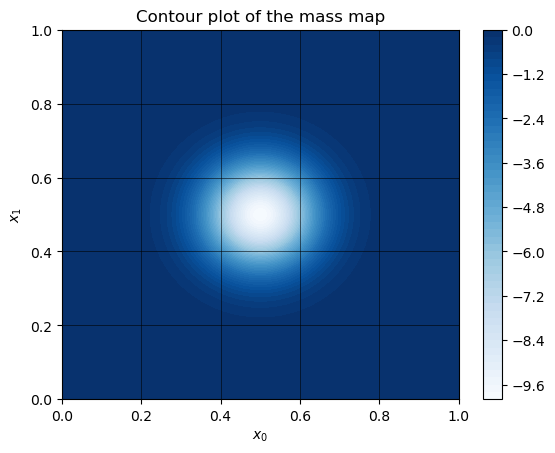

In [7]:
# visualize the mass map
x = [np.linspace(0, 1, 100), np.linspace(0, 1, 100)]
X, Y = np.meshgrid(x[0], x[1])
Z = -10 * np.exp(-(np.power(X - 0.5, 2) + np.power(Y - 0.5, 2)) / 0.02)

plt.contourf(X, Y, Z, levels=50, cmap='Blues')
plt.colorbar()
plt.title('Contour plot of the mass map')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.grid(True, color='black', linewidth=0.4)
plt.show()